In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
from statsmodels.tsa.stattools import acf
#import sktime as sk

## Read velocity

In [3]:
files=sorted(glob.glob('GOM/new_5km-radius/GOM-1-*2012*'))
files

['GOM/new_5km-radius/GOM-1-2012-01.nc',
 'GOM/new_5km-radius/GOM-1-2012-02.nc',
 'GOM/new_5km-radius/GOM-1-2012-03.nc',
 'GOM/new_5km-radius/GOM-1-2012-04.nc',
 'GOM/new_5km-radius/GOM-1-2012-05.nc',
 'GOM/new_5km-radius/GOM-1-2012-06.nc',
 'GOM/new_5km-radius/GOM-1-2012-07.nc',
 'GOM/new_5km-radius/GOM-1-2012-08.nc',
 'GOM/new_5km-radius/GOM-1-2012-09.nc',
 'GOM/new_5km-radius/GOM-1-2012-10.nc',
 'GOM/new_5km-radius/GOM-1-2012-11.nc',
 'GOM/new_5km-radius/GOM-1-2012-12.nc']

Using only one file:

In [4]:
vel=[]
for file in files:
    tmp=xr.open_dataset(file).load()
    tmp.close()
    vel.append(tmp)

vel=xr.concat(vel, dim='ocean_time')
vel['lon']=vel.lon.mean(dim='ocean_time')
vel['lat']=vel.lat.mean(dim='ocean_time')
vel['z']=vel.z.mean(dim='ocean_time')

vel=vel.set_coords(('lon','lat','z'))
vel

<xarray.Dataset>
Dimensions:     (ocean_time: 8784, node: 23, depth: 30)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2012-01-01T01:00:00 ... 2013-01-01
    lon         (node) float64 -94.13 -94.16 -94.13 ... -94.18 -94.15 -94.13
    lat         (node) float64 29.52 29.53 29.54 29.54 ... 29.6 29.6 29.6 29.61
    z           (depth, node) float64 -12.45 -12.0 -11.68 ... -0.1291 -0.1256
Dimensions without coordinates: node, depth
Data variables:
    temp        (ocean_time, depth, node) float64 16.57 16.58 ... 14.47 14.48
    salt        (ocean_time, depth, node) float64 29.19 29.36 ... 30.6 30.57
    w           (ocean_time, depth, node) float64 4.346e-06 ... 3.179e-07
    u           (ocean_time, depth, node) float64 -0.006107 ... -0.0975
    v           (ocean_time, depth, node) float64 0.004908 0.01094 ... 0.05773
Attributes: (12/33)
    file:              /scratch/user/d.kobashi/projects/hindcasts/projects/tx...
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Texas-Louisiana shelf hindcast with dyes
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model fast -heap-arrays -ip -O3
    tiling:            010x012
    ana_file:          /scratch/user/d.kobashi/source_code/COAWST/Functionals...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_SPFLUX,...
    history:           Sun Feb 20 15:39:41 2022: ncrename -v depth,z 5km-radi...
    NCO:               netCDF Operators version 5.0.6 (Homepage = http://nco....

In [5]:
vel.ocean_time.max()

<xarray.DataArray 'ocean_time' ()>
array('2013-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [6]:
vel['speed']=np.sqrt(vel.u**2+vel.v**2)
angles=np.arctan2(vel.v,vel.u)
vel['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)

In [7]:
vel.speed.mean(dim='ocean_time').isel(depth=0).mean('node')*3600*24

<xarray.DataArray 'speed' ()>
array(3265.55581796)

In [8]:
means=vel.isel(depth=0).mean(dim=['node'])
#means=vel.mean(dim=['depth','node'])
wd=means.direction.data
ws=means.speed.data

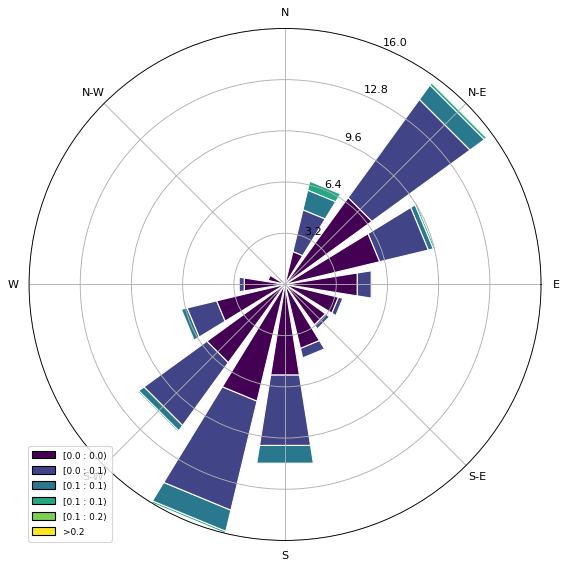

In [9]:
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

In [14]:
tmp=vel.mean(dim='depth').mean(dim='ocean_time')
tmp

<xarray.Dataset>
Dimensions:    (node: 23)
Coordinates:
    lon        (node) float64 -94.13 -94.16 -94.13 ... -94.18 -94.15 -94.13
    lat        (node) float64 29.52 29.53 29.54 29.54 ... 29.6 29.6 29.6 29.61
Dimensions without coordinates: node
Data variables:
    temp       (node) float64 24.36 24.36 24.36 24.36 ... 24.37 24.37 24.35
    salt       (node) float64 29.42 29.35 29.3 29.24 ... 28.57 28.42 28.39 28.41
    w          (node) float64 -5.42e-06 -3.175e-06 ... 4.397e-07 -2.903e-06
    u          (node) float64 -0.004325 -0.004186 ... -0.02248 -0.02079
    v          (node) float64 0.0008546 0.0005162 ... -0.00806 -0.001727
    speed      (node) float64 0.1107 0.1114 0.1099 ... 0.1017 0.09908 0.09304
    direction  (node) float64 182.5 176.7 182.1 186.8 ... 166.2 165.8 169.6

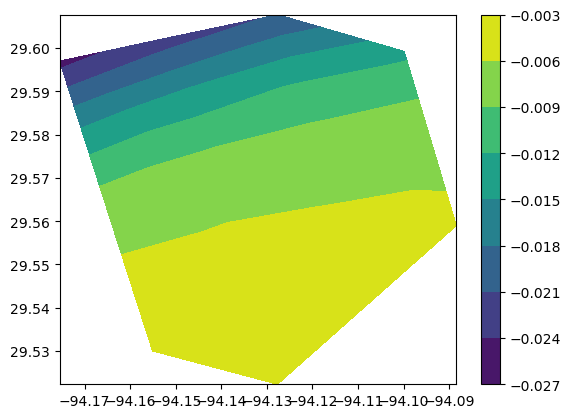

In [15]:
plt.tricontourf(tmp.lon,tmp.lat,tmp.u)
plt.colorbar()

In [16]:


from numpy.random import seed
from numpy.random import randint
seed(1)


def one_particle(vel,steps=200,num=1,sweeps=10):

## This function use the velocity field and move one particle based on random selection of depth and node and starting time in the timeseries.

    sizes=vel.sizes
    node=randint(0,sizes['node'],1)
    depth=randint(0,sizes['depth'],1)
    start=randint(0,sizes['ocean_time']-steps,1)
    time=vel.ocean_time.isel(ocean_time=start+np.arange(steps))
    time=(time.data-time[0].data)/np.timedelta64(1,'h')

    

    posx=np.zeros(steps)
    posy=np.zeros(steps)
    
    for ii in np.arange(steps-1):
        uold=vel.isel(ocean_time= start+ii,node=node,depth=depth).u.data
        unew=vel.isel(ocean_time= start+ii+1,node=node,depth=depth).u.data
        vold=vel.isel(ocean_time= start+ii+1,node=node,depth=depth).v.data
        vnew=vel.isel(ocean_time= start+ii,node=node,depth=depth).v.data
        tmpx=posx[ii]
        tmpy=posy[ii]
        
        for jj in np.arange(sweeps):
            u=(jj*unew+(sweeps-jj)*uold)/sweeps
            v=(jj*vnew+(sweeps-jj)*vold)/sweeps
            
            tmpx += u*3600/sweeps #time steps of one hour.
            tmpy += v*3600/sweeps
            
        #tmpy[ii]=vel.isel(ocean_time= start+np.arange(ii+1),node=node,depth=depth).v.integrate(coord='ocean_time',datetime_unit='s')
        #tmpx[ii]=vel.isel(ocean_time= start+np.arange(ii+1),node=node,depth=depth).u.integrate(coord='ocean_time',datetime_unit='s')
        posx[ii+1]=tmpx
        posy[ii+1]=tmpy
    
    particle=xr.Dataset(
    {
        "nodes": (["num"], node),
        "depths": (["num"], depth),
        "start": (["num"], start),
        "x":(["time"],posx),
        "y":(["time"],posy),
        "time":(["time"], time)
        },
        coords={"num": [num],
        
        })
    particle['r']=(('time',np.sqrt(particle.x.data**2+particle.y.data**2)))
    #particle['time']=time


    

    return particle

In [17]:
num=500 # Number of particles to release
steps=200 # Number of time steps of one hour.

particles=[]
for ii in np.arange(num):
    particles.append(one_particle(vel,steps,num=ii))

particles=xr.concat(particles,dim='num')
#particles #uncomment to to see the results. 

In [18]:
particles

<xarray.Dataset>
Dimensions:  (num: 500, time: 200)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 22 ... 19 3 4 21 6 22 0 5 18 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 17 ... 17 5 16 6 10 4 20 16 8
    start    (num) int64 5192 7813 144 7751 3462 5374 ... 1252 2604 73 1059 2895
    x        (num, time) float64 0.0 152.5 298.4 ... 5.42e+03 5.414e+03
    y        (num, time) float64 0.0 -27.64 -58.54 ... -6.015e+03 -6.185e+03
    r        (num, time) float64 0.0 155.0 304.1 ... 8.096e+03 8.22e+03

In [69]:
particles.(dim='num').r


<xarray.DataArray 'r' (time: 200)>
array([    0.        ,   298.05243317,   591.20688322,   882.37591832,
        1174.03755715,  1465.06826154,  1751.3428694 ,  2032.81260475,
        2309.64496211,  2582.81503262,  2854.10663451,  3125.40325254,
        3395.70320098,  3666.4119715 ,  3937.09589336,  4208.71128146,
        4482.98596508,  4759.28514032,  5034.33549496,  5307.16119181,
        5577.39453835,  5844.07617328,  6106.13071746,  6364.46512923,
        6619.06936019,  6867.98049037,  7111.50311713,  7348.58608978,
        7582.07309322,  7813.88919932,  8045.64015449,  8276.96605625,
        8506.59218965,  8734.35033516,  8962.03339482,  9189.95927663,
        9415.95539339,  9638.72689256,  9859.07364542, 10078.35499373,
       10297.30792826, 10517.44222906, 10740.9015456 , 10968.28845281,
       11196.82011717, 11423.25373598, 11644.21864113, 11857.87840189,
       12064.10969799, 12264.49595838, 12462.04587254, 12657.04760954,
       12848.58254941, 13037.72842191, 13225.91312339, 13414.51934399,
       13604.24941415, 13794.1928417 , 13983.42908496, 14172.71282304,
       14364.1930385 , 14557.70266862, 14749.12502317, 14936.00558459,
       15120.47540621, 15306.29892528, 15494.54703433, 15683.0909104 ,
       15870.16341949, 16057.15370146, 16242.91449136, 16425.61683158,
       16604.0884182 , 16778.63133075, 16950.49455919, 17119.19560136,
       17283.87802512, 17445.38639963, 17605.37194696, 17764.56399874,
...
       23464.95263183, 23604.88243608, 23744.50400307, 23884.17580913,
       24024.64790989, 24165.82264399, 24306.22896812, 24444.66067528,
       24581.67097439, 24718.47160837, 24858.13140382, 25002.89785727,
       25151.70019693, 25303.45406354, 25458.46597445, 25616.74283035,
       25777.29843771, 25938.85973074, 26100.61505793, 26259.83902611,
       26416.54680589, 26572.01657433, 26728.26691067, 26885.79664186,
       27043.44488275, 27200.34716578, 27356.41806312, 27511.44675187,
       27665.33969179, 27817.84115094, 27968.76435188, 28117.68711885,
       28266.54131072, 28417.41746505, 28571.73515042, 28732.60928735,
       28899.21536345, 29068.84636352, 29238.6337189 , 29406.86810881,
       29572.85316192, 29737.03258122, 29901.1357373 , 30065.47015061,
       30229.16419709, 30391.90802856, 30552.94239112, 30712.58225219,
       30872.3625667 , 31034.23073037, 31201.34950304, 31374.88499118,
       31550.6451294 , 31729.01555919, 31907.39778677, 32084.31688311,
       32259.35334516, 32432.52815881, 32602.62798977, 32767.55217785,
       32927.19218143, 33083.61540698, 33238.40051235, 33391.71834922,
       33544.15181413, 33695.80142771, 33845.77720612, 33994.03047554,
       34141.23190322, 34288.14170044, 34435.82781317, 34585.01159005,
       34735.07657262, 34884.33525332, 35030.63457817, 35173.15786222,
       35311.93427256, 35447.90085504, 35581.54311405, 35712.20178427])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0

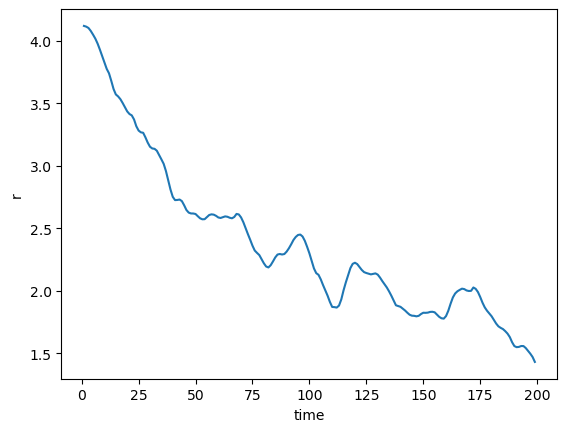

In [48]:
(4*particles.mean(dim='num').r.diff(dim='time')/360).plot()

Some figures. 

(-31458.33110004344,
 28700.280894954838,
 -12532.718223196436,
 10000.33813346562)

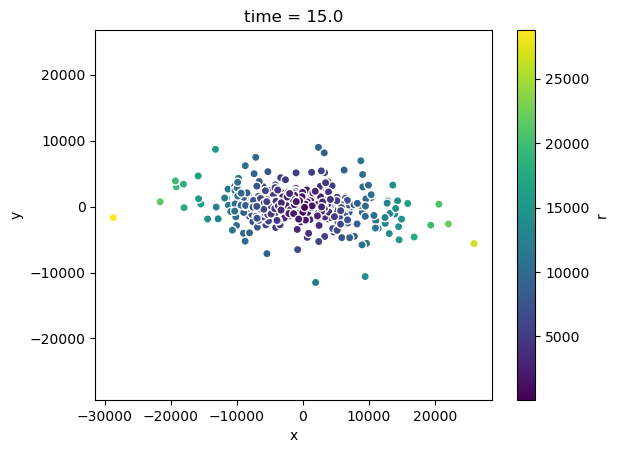

In [19]:
itime=15
particles.isel(time=itime).plot.scatter(x='x',y='y',hue='r')
plt.axis('equal')

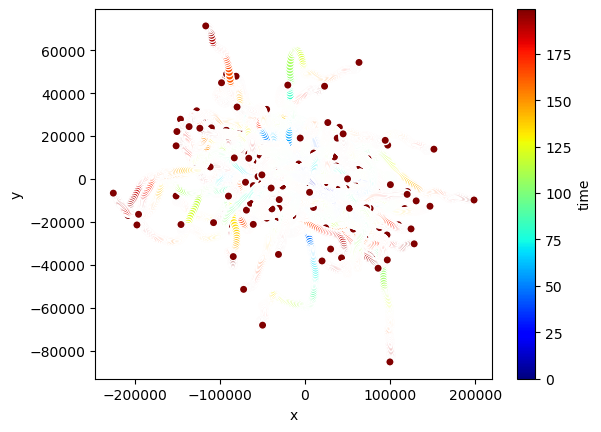

In [21]:
particles.plot.scatter(x='x',y='y',hue='time',cmap='jet')


In [19]:
particles.isel(time=itime)

<xarray.Dataset>
Dimensions:  (num: 500)
Coordinates:
    time     float64 15.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 ... 20 14 15 10 19 3 4 22 21 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 ... 14 27 14 18 17 5 29 16 6
    start    (num) int64 5192 7813 144 7751 3462 ... 6361 8680 4603 1864 6648
    x        (num) float64 2.057e+03 2.145e+03 -307.4 ... -1.033e+04 -3.302e+03
    y        (num) float64 -450.5 148.6 687.6 729.0 ... 1.846e+03 -689.3 -537.0
    r        (num) float64 2.106e+03 2.15e+03 753.1 ... 1.036e+04 3.345e+03

## Quantiles as function of time

In [19]:
particles.time

<xarray.DataArray 'time' (time: 200)>
array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
        60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166., 167.,
       168., 169., 170., 171., 172., 173., 174., 175., 176., 177., 178., 179.,
       180., 181., 182., 183., 184., 185., 186., 187., 188., 189., 190., 191.,
       192., 193., 194., 195., 196., 197., 198., 199.])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0

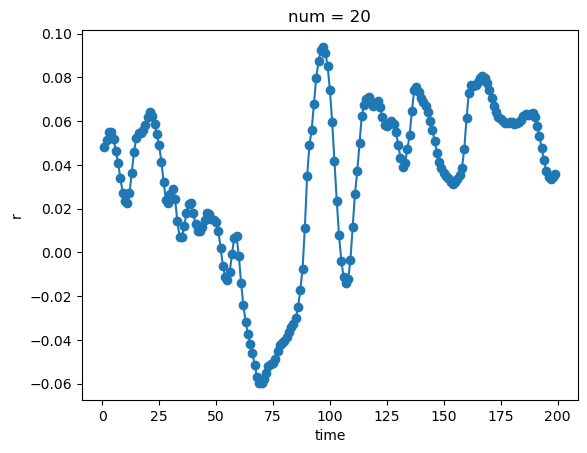

In [20]:
(particles.r.diff('time')/3600).mean(dim='num').plot(marker='o')



## Estimates of density. 
Adjusting for larger radius, 

Radius if a ring with inner radius $r_0$ and outer radius $r_0+\delta$ using $\delta=1$.
$$ A =\pi \delta (2r_0+\delta)$$

In [21]:
delR=100 # The thickness of the rings
num_bins=20 #number of bins
r_bins=np.append([5,10,20,30,50], (1+np.arange(num_bins))*delR)

r_bins


array([   5,   10,   20,   30,   50,  100,  200,  300,  400,  500,  600,
        700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
       1800, 1900, 2000])

In [22]:
particles

<xarray.Dataset>
Dimensions:  (num: 500, time: 200)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 22 ... 19 3 4 21 6 22 0 5 18 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 17 ... 17 5 16 6 10 4 20 16 8
    start    (num) int64 5192 7813 144 7751 3462 5374 ... 1252 2604 73 1059 2895
    x        (num, time) float64 0.0 152.5 298.4 ... 5.42e+03 5.414e+03
    y        (num, time) float64 0.0 -27.64 -58.54 ... -6.015e+03 -6.185e+03
    r        (num, time) float64 0.0 155.0 304.1 ... 8.096e+03 8.22e+03

In [23]:
np.shape(1./(np.pi*delR*(2*particles.r.data+delR)))

(500, 200)

In [1]:
particles.r.mean(dim='num').plot.hist(bins=40)

NameError: name 'particles' is not defined

In [25]:
particles['con']=((['num','time'],1./(np.pi*delR*(2*particles.r.data+delR)))) #Each particle contributes to density with 1/A.
#particles['A']=1./(np.pi*r_bins**2)
particles['A']=((['num','time'],1/(np.pi*particles.r.data**2+1e-6)))
particles

<xarray.Dataset>
Dimensions:  (num: 500, time: 200)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 22 ... 19 3 4 21 6 22 0 5 18 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 17 ... 17 5 16 6 10 4 20 16 8
    start    (num) int64 5192 7813 144 7751 3462 5374 ... 1252 2604 73 1059 2895
    x        (num, time) float64 0.0 152.5 298.4 ... 5.42e+03 5.414e+03
    y        (num, time) float64 0.0 -27.64 -58.54 ... -6.015e+03 -6.185e+03
    r        (num, time) float64 0.0 155.0 304.1 ... 8.096e+03 8.22e+03
    con      (num, time) float64 3.183e-05 7.765e-06 ... 1.954e-07 1.925e-07
    A        (num, time) float64 1e+06 1.326e-05 ... 4.856e-09 4.711e-09

In [22]:
particles_stacked=particles.stack(z=['num','time'])

In [70]:
rr=np.arange(5,500,5)
cc=np.zeros(len(rr))


In [71]:
rr

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390,
       395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455,
       460, 465, 470, 475, 480, 485, 490, 495])

In [72]:
particles.r.isel(num=1)

<xarray.DataArray 'r' (time: 200)>
array([    0.        ,   113.58620699,   269.77931504,   459.5335674 ,
         662.05172531,   864.0977015 ,  1060.04359576,  1248.87763583,
        1433.35964648,  1611.39694336,  1773.99788989,  1912.82619839,
        2022.68228961,  2100.44867069,  2143.65038686,  2151.85183639,
        2127.99834006,  2079.07791498,  2012.56455134,  1931.22569343,
        1842.89446523,  1760.90095018,  1687.37374611,  1617.96244731,
        1549.26829554,  1481.66516635,  1414.9504263 ,  1347.79893854,
        1282.19773437,  1221.68819867,  1167.3673104 ,  1118.90450436,
        1073.88756323,  1030.45174234,   988.38962683,   936.21353506,
         861.98243471,   775.26548666,   683.91600177,   575.17241604,
         463.79690589,   377.36732474,   323.291394  ,   311.27222365,
         343.37888428,   403.01499985,   476.8661814 ,   563.35161702,
         659.34491079,   763.52825887,   877.85137714,  1001.10833942,
        1129.87852499,  1256.41340658,  1373.37421055,  1478.09888447,
        1566.7181651 ,  1630.55309369,  1655.62030343,  1629.61934056,
        1547.5957814 ,  1412.47370079,  1373.85929753,  1503.61096962,
        1659.17401132,  1816.00702462,  1996.58271934,  2203.21861788,
        2422.24129406,  2652.61684026,  2900.57868389,  3173.40540051,
        3479.00463436,  3818.87154294,  4193.10582973,  4588.89355377,
        4987.90330975,  5387.94086154,  5798.71793353,  6229.6761498 ,
...
       24447.75722267, 24857.56360755, 25215.94928439, 25559.50772304,
       25898.46819744, 26216.70528405, 26503.21401709, 26764.51859251,
       27020.57278487, 27284.24608671, 27552.01957088, 27815.05359323,
       28057.15065896, 28267.71565376, 28449.1161853 , 28611.62256879,
       28763.94267373, 28909.44808506, 29044.26223873, 29156.62031547,
       29231.88296216, 29261.80880041, 29244.49058634, 29166.35842925,
       29015.48046431, 28801.97122289, 28539.23042737, 28232.35240309,
       27899.39013743, 27602.90923219, 27420.08497522, 27370.48938102,
       27437.08173808, 27593.20263597, 27802.65344294, 28041.94755313,
       28298.47219409, 28587.23847439, 28927.96894004, 29315.35404923,
       29728.84862739, 30156.67928014, 30581.14436083, 31007.03485553,
       31455.09784031, 31918.92961906, 32388.12523054, 32854.74160763,
       33320.93726366, 33792.69718286, 34274.82582146, 34764.06460727,
       35249.39477763, 35721.19868068, 36190.5641212 , 36674.93377695,
       37166.12029415, 37656.41667317, 38145.6544188 , 38630.5621924 ,
       39109.77569281, 39589.51692585, 40078.34006554, 40573.44177498,
       41068.85332309, 41568.56798915, 42066.3049112 , 42549.4837343 ,
       43010.24308607, 43437.26854125, 43827.60685362, 44185.46491973,
       44521.86926717, 44846.18452289, 45161.7133265 , 45467.92531221,
       45764.23194377, 46058.44777818, 46357.07536944, 46664.75865741])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0
    num      int64 1

In [73]:
time_stat=np.zeros_like(rr)
time_stat2=np.zeros_like(rr)
N=np.zeros_like(rr)
for ii in np.arange(len(rr)):
    for num in particles.num:
        
        indx=np.where(np.diff(np.sign(particles.isel(num=num).r-rr[ii])) !=0)[0]
        #indx=indx[0]
        time_stat[ii]+=particles.time[indx].sum()
        time_stat2[ii]+=(particles.time[indx]**2).sum()
        N[ii] += len(indx)



In [74]:
time_mn=time_stat/N
time_std=np.sqrt(time_stat2/N-time_mn**2)

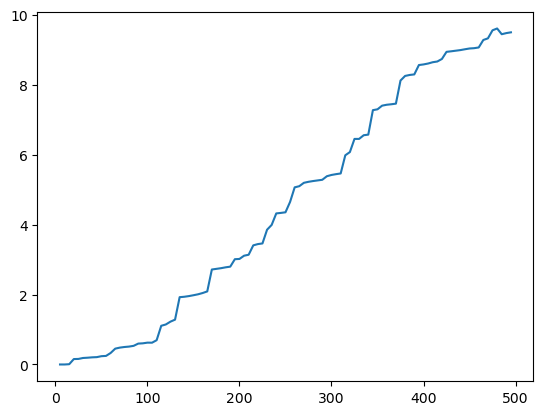

In [75]:
plt.plot(rr,time_mn)

In [76]:
1/np.mean(np.diff(time_mn[10:50])/5)

47.46349525751107

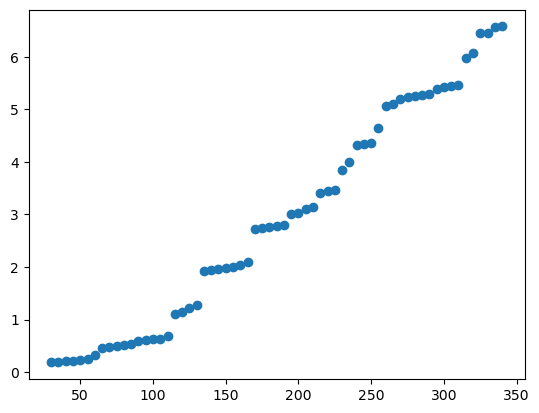

In [28]:
plt.plot(rr[5:68],time_mn[5:68],'o')


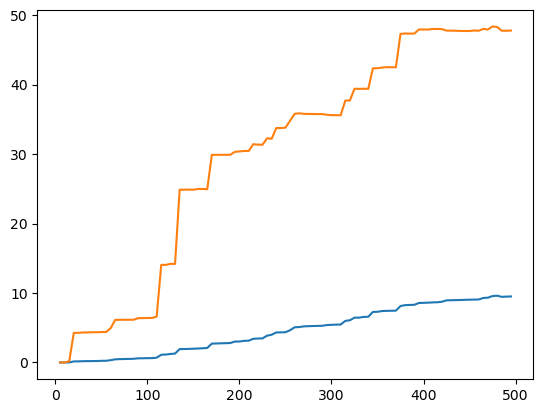

In [77]:
plt.plot(rr,time_mn)
plt.plot(rr,1.96*time_std)

In [78]:
time_nrm=time_mn/(2*np.pi*rr)


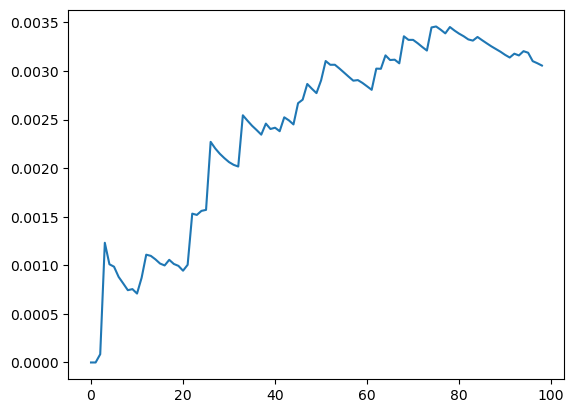

In [82]:
plt.plot(time_nrm)

(0.0, 500.0)

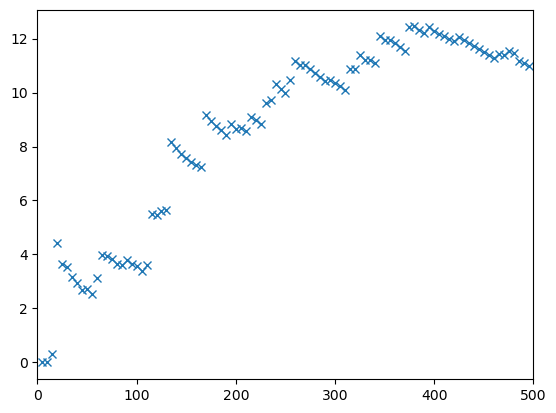

In [81]:
plt.plot(rr,3600*time_mn/(2*np.pi*rr),'x')
plt.xlim(0,500)

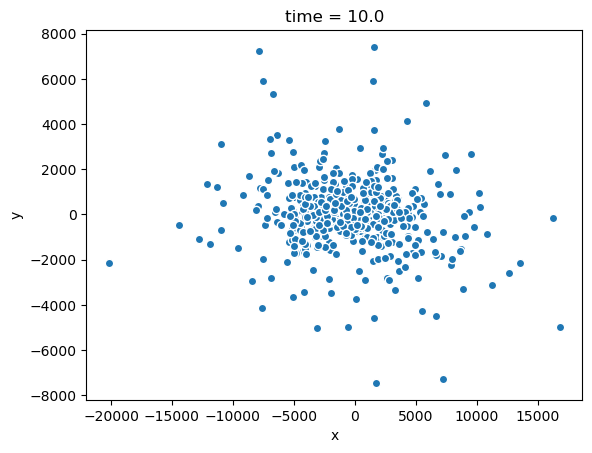

In [33]:
particles.isel(time=10).plot.scatter(x='x',y='y')

In [687]:

particles.isel(time=2).groupby_bins('r',r_bins).count()

<xarray.Dataset>
Dimensions:  (r_bins: 24)
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]
    time     float64 2.0
Data variables:
    nodes    (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    depths   (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    start    (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    x        (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    y        (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    r        (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    con      (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan
    A        (r_bins) float64 nan 4.0 2.0 9.0 32.0 77.0 ... 2.0 1.0 1.0 1.0 nan

(0.0, 8.0)

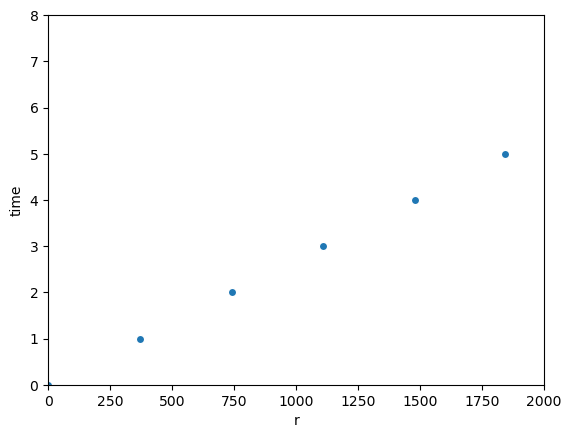

In [39]:
particles.mean(dim='num').plot.scatter(x='r',y='time')
plt.xlim(0,2000)
plt.ylim(0,8)

In [ ]:
(dim='num').plot.scatter(x='r',y='time')
#plt.xlim(0,2000)
#plt.ylim(0,8)

(0.0, 6.0)

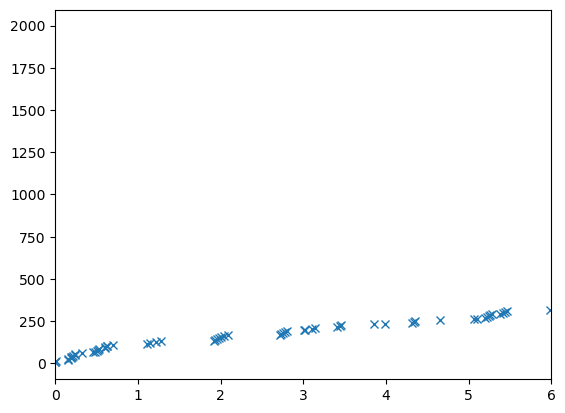

In [40]:
plt.plot(time_mn,rr,'x')
plt.xlim(0,6)

(0.0, 1000.0)

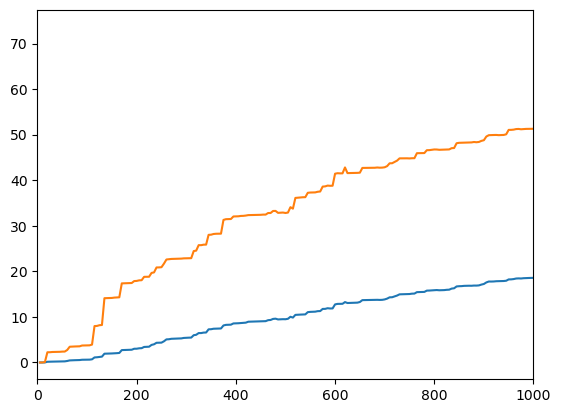

In [41]:
plt.plot(rr,time_mn)
plt.plot(rr,time_mn+0.96*time_std)
plt.xlim(0,1000)

In [42]:
np.mean(np.diff(time_stat)/5)


10.983919597989951

In [508]:
(particles.time[indx]**2).sum()

<xarray.DataArray 'time' ()>
array(16.)

In [402]:
particles.isel(num=1).isel(time=indx[1]+1)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     float64 175.0
    num      int64 1
Data variables:
    nodes    int64 17
    depths   int64 18
    start    int64 7101
    x        float64 -3.793e+04
    y        float64 -1.54e+04
    r        float64 4.093e+04

In [366]:
time_mean=[]
for r in rr:
    particles.where(np.abs(particles.r-1303)<5,drop=True).isel(num=1).time.mean()

<xarray.DataArray 'time' ()>
array(22.22727273)
Coordinates:
    num      int64 13

In [511]:
tmp=particles.stack(z=['time','num'])

In [ ]:
for r in rr:
    tt=tmp.r-r

In [617]:
tt

<xarray.DataArray 'r' ()>
array(0.01763037)

In [43]:
c=[]
l=5*1.2
for r in rr:
    tt=np.exp(-((tmp.r-r)/l)**2).sum()/np.pi**(1.5)/l**3
    c.append(tt)

c=xr.concat(c,dim='r')
c=c.assign_coords(r=rr)

In [44]:
c

<xarray.DataArray 'r' (r: 399)>
array([0.20846205, 0.02947087, 0.00635506, 0.00501256, 0.00567243,
       0.00796967, 0.00908745, 0.00911352, 0.00849791, 0.00913637,
       0.0101699 , 0.01283126, 0.01391941, 0.01575046, 0.01998732,
       0.02007636, 0.01525638, 0.01102034, 0.01218322, 0.01286433,
       0.01566172, 0.01884093, 0.01741934, 0.01697302, 0.0181276 ,
       0.02089699, 0.01946132, 0.01935039, 0.0248815 , 0.02946907,
       0.03182899, 0.02632936, 0.02017633, 0.01816381, 0.01779264,
       0.01842772, 0.02077727, 0.02106173, 0.02176142, 0.01878579,
       0.01866731, 0.02253037, 0.02259504, 0.02253713, 0.02294905,
       0.0217881 , 0.02039998, 0.02043672, 0.0217585 , 0.02769851,
       0.03207267, 0.02938915, 0.02686322, 0.02805302, 0.02771791,
       0.02422467, 0.02099518, 0.02297537, 0.0244392 , 0.02627837,
       0.02727126, 0.02827706, 0.0273972 , 0.02711584, 0.02542581,
       0.02286692, 0.02663124, 0.03297618, 0.0378747 , 0.0356689 ,
       0.02942017, 0.02282251, 0.02150863, 0.02750158, 0.02978165,
       0.02873353, 0.02855783, 0.02839524, 0.02573788, 0.02666096,
       0.02805343, 0.02717992, 0.02529753, 0.02421279, 0.02157602,
       0.01924799, 0.02417706, 0.03029459, 0.03036958, 0.02691299,
       0.02756328, 0.03295512, 0.03559085, 0.03155565, 0.03008324,
       0.03146777, 0.03351486, 0.03283421, 0.02878767, 0.02873547,
...
       0.03809801, 0.03682258, 0.03722021, 0.03753936, 0.03137186,
       0.02822423, 0.03008148, 0.03105573, 0.03214552, 0.03508132,
       0.0327028 , 0.02860027, 0.03010944, 0.03415416, 0.03759585,
       0.03639887, 0.03387919, 0.03737942, 0.03957236, 0.03730701,
       0.03521031, 0.0321027 , 0.03472746, 0.03279889, 0.02975322,
       0.03260676, 0.03443909, 0.03280849, 0.03520037, 0.03850222,
       0.03635138, 0.03651615, 0.03785804, 0.03169598, 0.02583969,
       0.02574441, 0.02986959, 0.03427323, 0.03118073, 0.02565968,
       0.02459499, 0.02416926, 0.02968111, 0.03442156, 0.03053596,
       0.02851996, 0.03205775, 0.03168126, 0.02996951, 0.03001222,
       0.02765409, 0.02791647, 0.03209187, 0.03356378, 0.03155198,
       0.0260818 , 0.02452409, 0.02944696, 0.03684044, 0.0366305 ,
       0.02958553, 0.0281914 , 0.03462663, 0.03929299, 0.03565296,
       0.03035569, 0.0291173 , 0.02995588, 0.03135605, 0.02685137,
       0.02544882, 0.03178762, 0.03633658, 0.03407753, 0.02961319,
       0.02527481, 0.02365121, 0.02699439, 0.02703584, 0.02488833,
       0.02586005, 0.03030715, 0.03407676, 0.03211129, 0.03096551,
       0.03099219, 0.0317164 , 0.02956263, 0.0278721 , 0.02951636,
       0.02813563, 0.02434253, 0.02254449, 0.02310373, 0.02608742,
       0.03308187, 0.03456026, 0.03381591, 0.03575773])
Coordinates:
  * r        (r) int64 5 10 15 20 25 30 35 ... 1970 1975 1980 1985 1990 1995

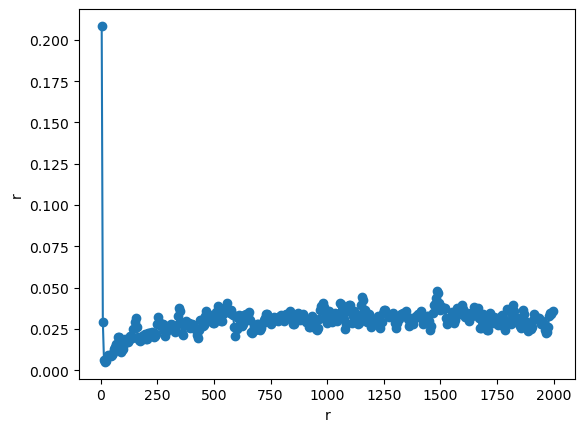

In [55]:
c.plot(x='r',marker='o')
#plt.xlim(0,20)


(0.0, 1.5)

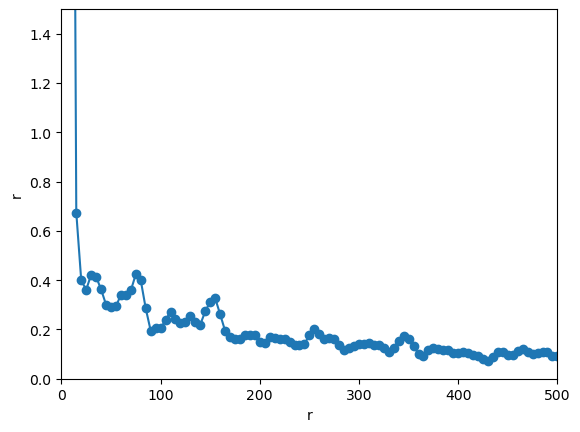

In [54]:
(10**4*c/(2*np.pi*c.r)).plot(marker='o') 
plt.xlim(0,500)
plt.ylim(0,1.5)

In [233]:
c.sum()

<xarray.DataArray 'r' ()>
array(17.41357172)

bins in radius.


In [47]:
cons=[]
for ii in np.arange(particles.sizes['time']):
    try:
        tmp=particles.isel(time=np.arange(ii)).groupby_bins('r',r_bins).sum().con
        #tmp=particles.isel(time=ii).groupby_bins('r',r_bins).sum().con
        tmp['time']=particles.isel(time=ii).time
    except:
        tmp=xr.zeros_like(particles.isel(time=1).groupby_bins('r',r_bins).sum().con)
        tmp['time']=ii
    cons.append(tmp)
cons=xr.concat(cons,dim='time')


In [48]:
cons

<xarray.DataArray 'con' (time: 200, r_bins: 24)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 1.49310498e-04, 2.06023421e-05, ...,
                   nan,            nan, 7.89063702e-07],
       ...,
       [           nan, 1.96593170e-04, 1.23802420e-04, ...,
        2.96925628e-04, 2.85106446e-04, 2.63392000e-04],
       [           nan, 1.96593170e-04, 1.23802420e-04, ...,
        2.97826211e-04, 2.85964989e-04, 2.63392000e-04],
       [           nan, 1.96593170e-04, 1.23802420e-04, ...,
        2.98696825e-04, 2.86784209e-04, 2.64960852e-04]])
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 196.0 197.0 198.0 199.0

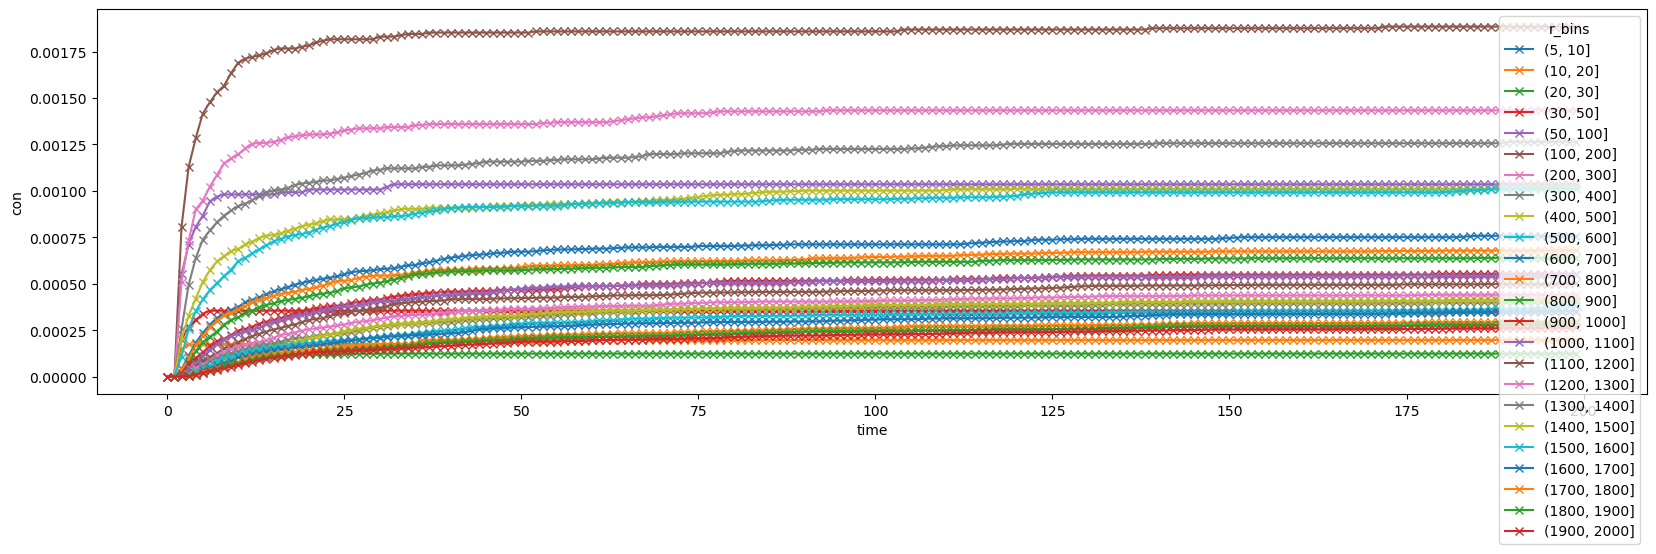

In [50]:
cons.plot.line(x='time',marker='x',aspect=4, size=5)
#plt.yscale('log')
#plt.xlim(1,30)


In [143]:
cons

<xarray.DataArray 'con' (time: 50, r_bins: 24)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 1.48623746e-04, 2.07289985e-05, ...,
                   nan,            nan, 7.94399084e-07],
       ...,
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.05824787e-04, 1.95555986e-04, 1.90958334e-04],
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.07593645e-04, 1.96403482e-04, 1.93361377e-04],
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.08489496e-04, 2.00528940e-04, 1.94936021e-04]])
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0

In [109]:
cons.r_bins

<xarray.DataArray 'r_bins' (r_bins: 24)>
array([Interval(5, 10, closed='right'), Interval(10, 20, closed='right'),
       Interval(20, 30, closed='right'), Interval(30, 50, closed='right'),
       Interval(50, 100, closed='right'), Interval(100, 200, closed='right'),
       Interval(200, 300, closed='right'), Interval(300, 400, closed='right'),
       Interval(400, 500, closed='right'), Interval(500, 600, closed='right'),
       Interval(600, 700, closed='right'), Interval(700, 800, closed='right'),
       Interval(800, 900, closed='right'), Interval(900, 1000, closed='right'),
       Interval(1000, 1100, closed='right'),
       Interval(1100, 1200, closed='right'),
       Interval(1200, 1300, closed='right'),
       Interval(1300, 1400, closed='right'),
       Interval(1400, 1500, closed='right'),
       Interval(1500, 1600, closed='right'),
       Interval(1600, 1700, closed='right'),
       Interval(1700, 1800, closed='right'),
       Interval(1800, 1900, closed='right'),
       Interval(1900, 2000, closed='right')], dtype=object)
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]

In [110]:
r_bins

array([   5,   10,   20,   30,   50,  100,  200,  300,  400,  500,  600,
        700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
       1800, 1900, 2000])

In [111]:
rr=r_bins[0:-1]+np.diff(r_bins)/2
rr

array([   7.5,   15. ,   25. ,   40. ,   75. ,  150. ,  250. ,  350. ,
        450. ,  550. ,  650. ,  750. ,  850. ,  950. , 1050. , 1150. ,
       1250. , 1350. , 1450. , 1550. , 1650. , 1750. , 1850. , 1950. ])

In [144]:
cons=cons.assign_coords(rr=('r_bins',rr))

(0.0, 200.0)

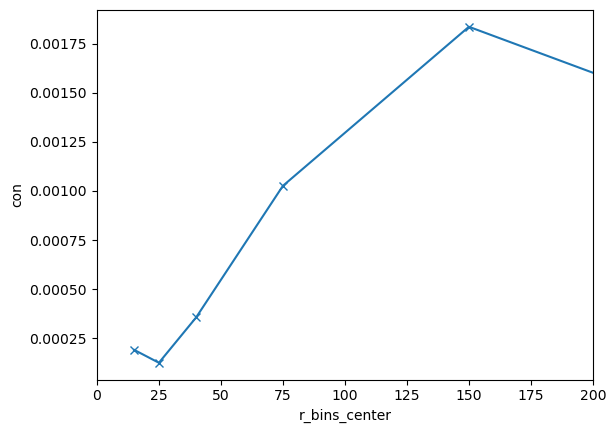

In [51]:
cons.isel(time=slice(10,100)).mean(dim='time').plot(marker='x')
plt.xlim(0,200)

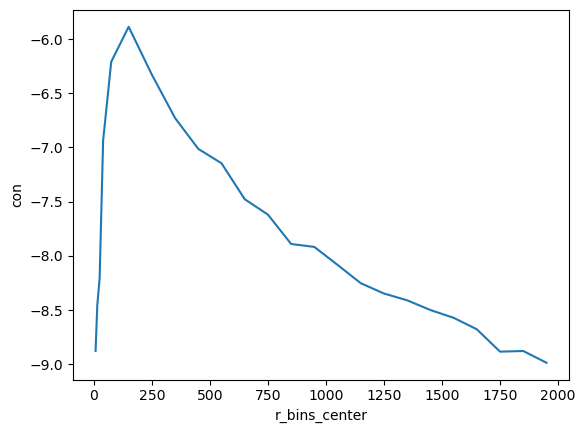

In [520]:
np.log(cons.mean(dim='time')).plot()

### To be continued...

In [609]:
temp=xr.open_dataset('GOM/temp.nc')

(0.0, 250.0)

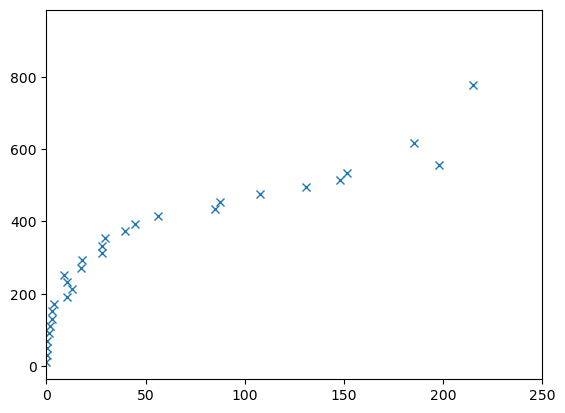

In [615]:
plt.plot(temp.time,temp.r,'x')
plt.xlim(0,250)

In [611]:
temp

<xarray.Dataset>
Dimensions:  (time: 50, r: 50)
Coordinates:
  * time     (time) float64 0.0 0.3 0.2 0.5 1.5 1.7 ... nan 413.0 nan nan nan
  * r        (r) float64 10.0 30.2 50.41 70.61 90.82 ... 939.4 959.6 979.8 1e+03
Data variables:
    *empty*

In [5]:
test=xr.open_dataset('/home/guttorm/Github/ACTOM/Test_docker/Output/Sensor_locations.nc')
test

<xarray.Dataset>
Dimensions:        (sensor: 8, source: 50)
Coordinates:
  * sensor         (sensor) int64 1 2 3 4 5 6 7 8
  * source         (source) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
Data variables:
    x_sensor       (sensor) float64 ...
    y_sensor       (sensor) float64 ...
    ns_per_sensor  (sensor) int64 ...
    x_source       (source) float64 ...
    y_source       (source) float64 ...
    N_over         int64 ...

In [6]:
test.x_sensor

<xarray.DataArray 'x_sensor' (sensor: 8)>
array([-9103413.395323, -9099294.766339, -9098083.404873, -9100930.104318,
       -9100687.832025, -9101959.761564, -9097417.156067, -9097538.292214])
Coordinates:
  * sensor   (sensor) int64 1 2 3 4 5 6 7 8

## Power analysis more sources

In [4]:
stats=xr.open_dataset('Temp_data/statistics_global.nc')
stats

<xarray.Dataset>
Dimensions:               (source: 75, x: 250, y: 250, dt: 3)
Coordinates:
  * dt                    (dt) float64 900.0 1.8e+03 3.6e+03
  * x                     (x) float64 2.748e+05 2.749e+05 ... 3.161e+05
  * y                     (y) float64 3.198e+06 3.198e+06 ... 3.22e+06 3.22e+06
Dimensions without coordinates: source
Data variables:
    mean                  (source, x, y) float64 ...
    var                   (source, x, y) float64 ...
    max                   (source, x, y) float64 ...
    delta_mean            (source, dt, x, y) float64 ...
    delta_mean_abs        (source, dt, x, y) float64 ...
    delta_var             (source, dt, x, y) float64 ...
    delta_max             (source, dt, x, y) float64 ...
    delta_min             (source, dt, x, y) float64 ...
    location_probability  (source) float32 ...
    x_source              (source) float64 ...
    y_source              (source) float64 ...
    source tag            (source) int32 ...
Attributes: (12/30)
    max_prob:             0.0007019417826086283
    sum_prob:             1.2551407
    risk file:            ar56.8928.bm1310.slp3d.migration_conv_AGF_1_netcdf.nc
    threshold:            0.1
    cluster:              dbscan
    Probe file:           Indata/Probes/Probes_ar56_ex3.nc
    ...                   ...
    ny:                   100
    maxvol:               140000.0
    minvol:               460.0
    Fill type:            nearest extrapolation
    Downsampling:         False
    Downsampling factor:  16.0

In [532]:
stats.where(np.abs(stats.x-stats.x_source)< 5000,drop=True)


<xarray.Dataset>
Dimensions:               (source: 75, x: 160, y: 250, dt: 3)
Coordinates:
  * dt                    (dt) float64 900.0 1.8e+03 3.6e+03
  * x                     (x) float64 2.822e+05 2.824e+05 ... 3.086e+05
  * y                     (y) float64 3.198e+06 3.198e+06 ... 3.22e+06 3.22e+06
Dimensions without coordinates: source
Data variables:
    mean                  (source, x, y) float64 nan nan nan nan ... 0.0 0.0 0.0
    var                   (source, x, y) float64 nan nan nan nan ... 0.0 0.0 0.0
    max                   (source, x, y) float64 nan nan nan nan ... 0.0 0.0 0.0
    delta_mean            (source, dt, x, y) float64 nan nan nan ... 0.0 0.0 0.0
    delta_mean_abs        (source, dt, x, y) float64 nan nan nan ... 0.0 0.0 0.0
    delta_var             (source, dt, x, y) float64 nan nan nan ... 0.0 0.0 0.0
    delta_max             (source, dt, x, y) float64 nan nan nan ... 0.0 0.0 0.0
    delta_min             (source, dt, x, y) float64 nan nan nan ... 0.0 0.0 0.0
    location_probability  (source, x) float32 nan nan nan ... 95.97 95.97 95.97
    x_source              (source, x) float64 nan nan ... 3.037e+05 3.037e+05
    y_source              (source, x) float64 nan nan ... 3.211e+06 3.211e+06
    source tag            (source, x) float64 nan nan nan nan ... 74.0 74.0 74.0
Attributes: (12/30)
    max_prob:             0.0007019417826086283
    sum_prob:             1.2551407
    risk file:            ar56.8928.bm1310.slp3d.migration_conv_AGF_1_netcdf.nc
    threshold:            0.1
    cluster:              dbscan
    Probe file:           Indata/Probes/Probes_ar56_ex3.nc
    ...                   ...
    ny:                   100
    maxvol:               140000.0
    minvol:               460.0
    Fill type:            nearest extrapolation
    Downsampling:         False
    Downsampling factor:  16.0

In [74]:
def GA_shift_to_source(inarr):
    x_mid=int(np.fix(stats.dims['x']/2))
    y_mid=int(np.fix(stats.dims['y']/2))
    indx=inarr['mean'].argmax(dim=['x','y'])
    
    #mxs=inarr.isel(x=indx['x'],y=indx['y'])
    inarr=inarr.shift(x=x_mid-indx['x'].values,y=y_mid-indx['y'].values)
    inarr['x']=inarr.x-inarr.x.isel(x=x_mid)
    inarr['y']=inarr.y-inarr.y.isel(y=y_mid)
    return inarr

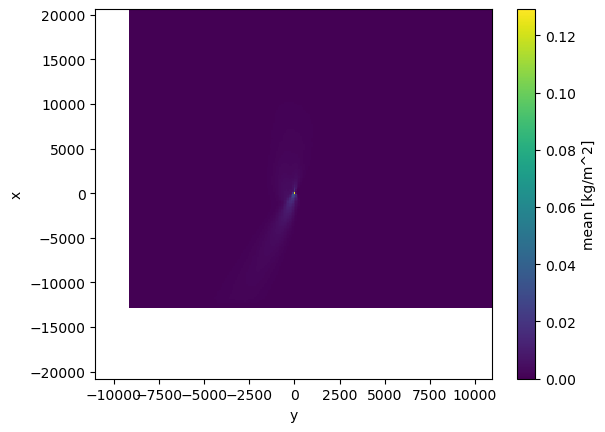

In [128]:
shifted['mean'].isel(source=10).plot()

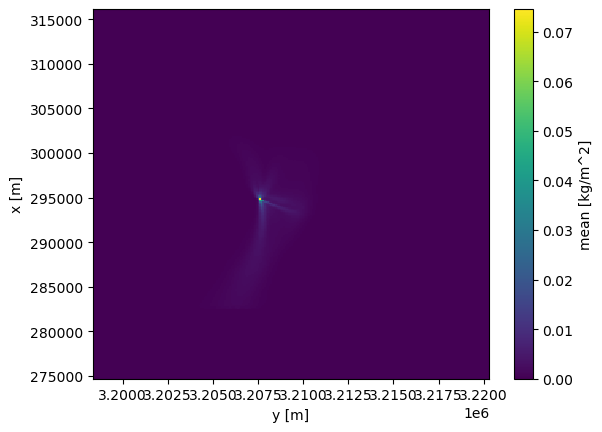

In [134]:
stats.isel(source=1)['mean'].plot()

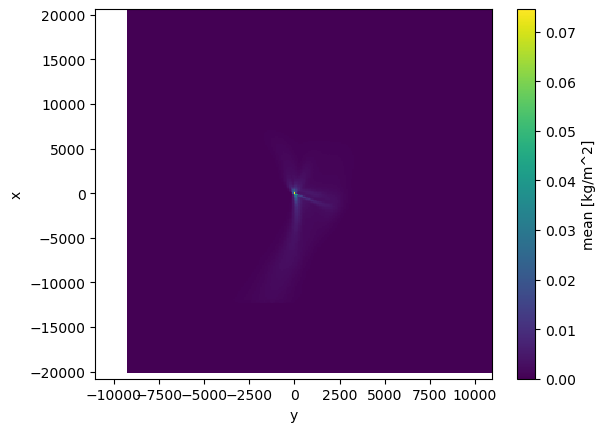

In [135]:
tmp=GA_shift_to_source(stats.isel(source=1))

tmp['mean'].plot()

In [ ]:

    x0=mxs.x
    y0=mxs.y
    xx,yy=np.meshgrid(inarr.x-x0,inarr.y-y0, indexing='ij')
    rr=np.sqrt(xx*xx+yy*yy)
    inarr=inarr.assign_coords(xx=(['x'],(inarr.x-x0).data))
    inarr=inarr.assign_coords(yy=(['y'],(inarr.y-y0).data))
    inarr=inarr.assign_coords(rr=(['x','y'],rr))
    inarr=inarr.drop('x')
    inarr=inarr.drop('y')
    return inarr

In [122]:
shifted=[]
for source in stats.source.values:
    shifted.append(GA_shift_to_source(stats.isel(source=source)))

shifted=xr.concat(shifted,dim='source')
shifted['r']=np.sqrt(shifted.x**2+shifted.y**2)
shifted=shifted.assign_coords(r=shifted.r)

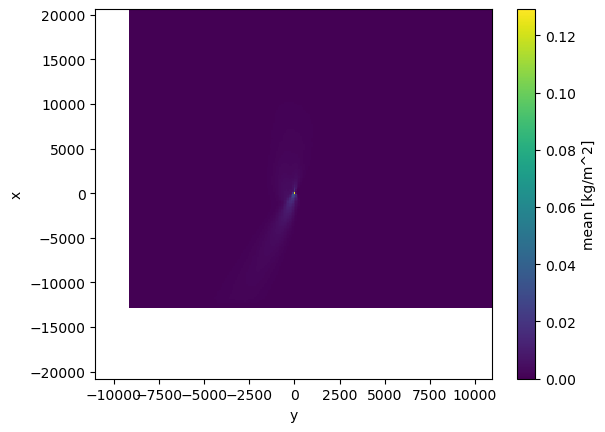

In [137]:
shifted['mean'].isel(source=10).plot()

In [84]:
stack=shifted.stack(z=['x','y'])
stack['r']=np.sqrt(stack.x**2+stack.y**2)

In [89]:
stack=stack.assign_coords(r=stack.r)

(-2000.0, 2000.0)

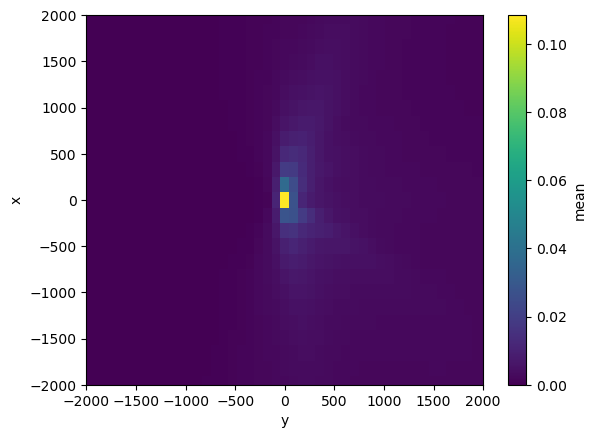

In [148]:
stack.mean(dim='source').dropna('z')['mean'].unstack('z').plot()
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)

In [116]:
stack['mean'].dropna(dim='z')

<xarray.DataArray 'mean' (source: 75, z: 21158)>
array([[0.00000000e+00, 6.32959014e-06, 1.38135834e-05, ...,
        1.84397028e-12, 7.91275338e-13, 0.00000000e+00],
       [0.00000000e+00, 2.98420773e-07, 9.93103714e-07, ...,
        1.01420221e-08, 5.31861638e-09, 0.00000000e+00],
       [0.00000000e+00, 1.33438458e-07, 3.28893914e-07, ...,
        2.34021465e-07, 1.08643357e-07, 0.00000000e+00],
       ...,
       [0.00000000e+00, 9.52548912e-37, 3.95094289e-36, ...,
        1.06462922e-05, 4.78061546e-06, 0.00000000e+00],
       [0.00000000e+00, 1.49944469e-33, 1.73506069e-32, ...,
        1.72864759e-05, 8.78148391e-06, 2.76491917e-07],
       [0.00000000e+00, 6.24475551e-49, 1.94948982e-48, ...,
        5.26893218e-06, 2.05301382e-06, 0.00000000e+00]])
Coordinates:
  * z        (z) object MultiIndex
  * x        (z) float64 -1.227e+04 -1.227e+04 ... 1.227e+04 1.227e+04
  * y        (z) float64 -6.239e+03 -6.151e+03 ... 6.063e+03 6.151e+03
    r        (z) float64 1.376e+04 1.372e+04 1.368e+04 ... 1.368e+04 1.372e+04
Dimensions without coordinates: source
Attributes:
    unit:     kg/m^2

(0.0, 500.0)

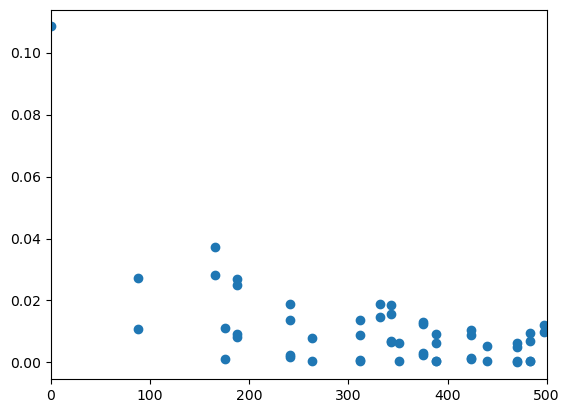

In [182]:
plt.scatter(y=stack['mean'].mean(dim='source'),x=stack.r)
plt.xlim(0,500)

In [168]:
tmp=stack.mean(dim='source').groupby('r').mean()
tmp

<xarray.Dataset>
Dimensions:               (dt: 3, r: 31427)
Coordinates:
  * dt                    (dt) float64 900.0 1.8e+03 3.6e+03
  * r                     (r) float64 0.0 87.88 165.8 ... 2.341e+04 2.345e+04
Data variables:
    mean                  (r) float64 0.1084 0.01911 0.02833 ... 0.0 0.0 0.0
    var                   (r) float64 0.04282 0.006004 0.003888 ... 0.0 0.0 0.0
    max                   (r) float64 0.9292 0.3813 0.3154 ... 0.0 0.0 0.0
    delta_mean            (r, dt) float64 9.68e-05 0.0001936 ... 0.0 0.0
    delta_mean_abs        (r, dt) float64 0.006476 0.01284 0.02507 ... 0.0 0.0
    delta_var             (r, dt) float64 0.0007012 0.002632 ... 0.0 0.0
    delta_max             (r, dt) float64 0.1587 0.2829 0.4285 ... 0.0 0.0 0.0
    delta_min             (r, dt) float64 -0.1157 -0.2163 -0.3702 ... 0.0 0.0
    location_probability  (r) float32 52.32 52.32 52.32 ... 52.32 52.32 52.32
    x_source              (r) float64 2.975e+05 2.975e+05 ... 2.975e+05
    y_source              (r) float64 3.209e+06 3.209e+06 ... 3.209e+06
    source tag            (r) float64 37.0 37.0 37.0 37.0 ... 37.0 37.0 37.0

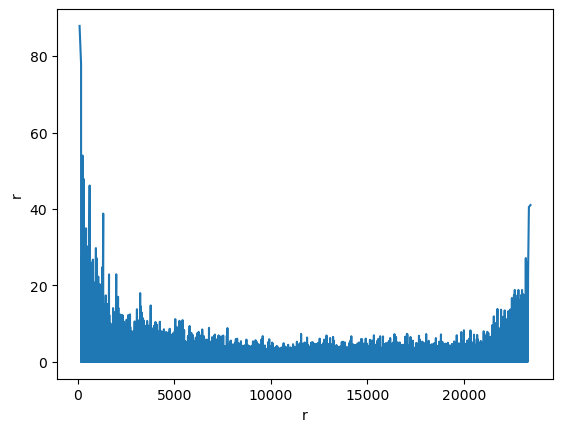

In [177]:
tmp.r.diff(dim='r').plot()

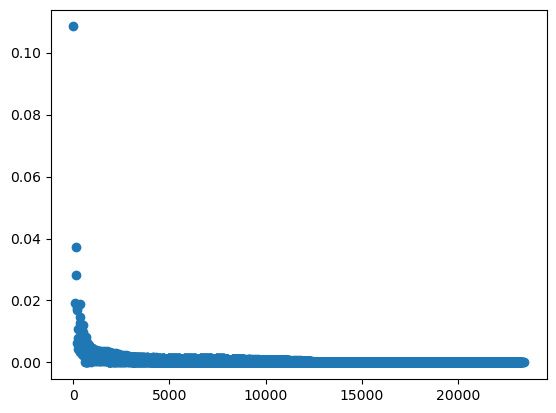

In [170]:
plt.scatter(x=tmp.r,y=tmp['mean'])

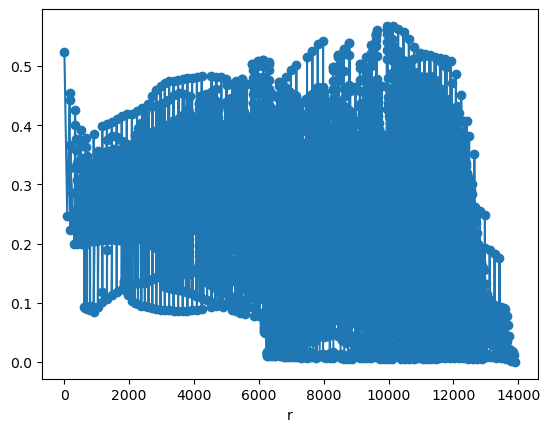

In [173]:
ES=(tmp['mean']/np.sqrt(tmp['var']))
#ES=ES.where(ES>1,drop=True)
ES.plot(marker='o')


/home/guttorm/miniconda3/envs/test-env/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


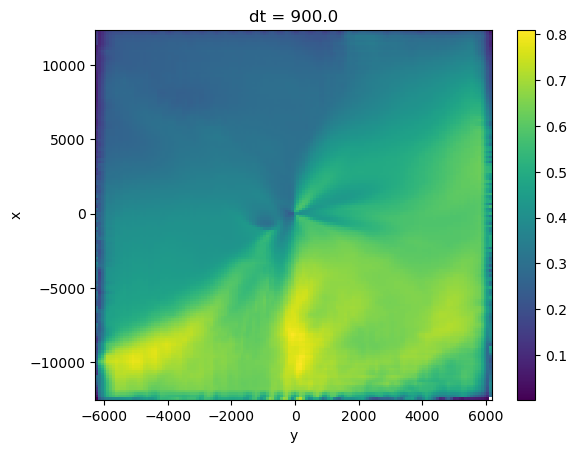

In [425]:
ES=(shifted['delta_mean_abs'].isel(dt=0).mean(dim='source')/np.sqrt(shifted['delta_var']/2).isel(dt=0).mean(dim='source'))
ES=ES.where(ES>1e-3,drop=True)
ES.plot()


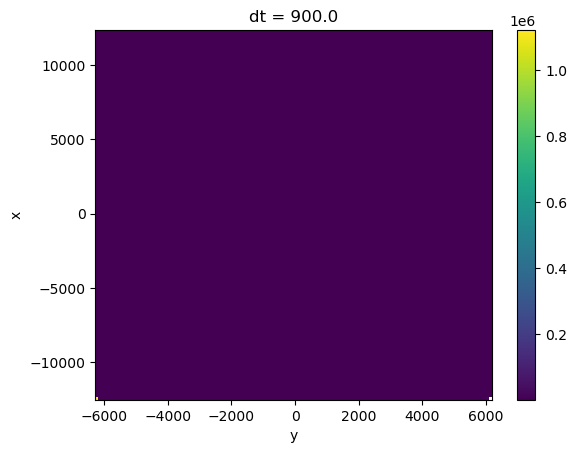

In [426]:
tmp=(((1.96+0.84)/ES)**2)
tmp.plot()
#.plot(x='x',y='y')
#plt.xlim(-5000,5000)
#plt.ylim(-5000,5000)

In [417]:
ssmn=stack['mean'].groupby_bins('r', np.r_[0:500:5]).mean(skipna=True)
sssd=stack['var'].groupby_bins('r', np.r_[0:500:5]).mean(skipna=True)

In [418]:
ssmn.isel(source=0)

<xarray.DataArray 'mean' (r_bins: 99)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.0225322 ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.04237689,        nan,
       0.00718403,        nan, 0.02360767,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.01368817,        nan,
              nan,        nan, 0.0051708 ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.00698526,        nan,        nan,
              nan, 0.02529077,        nan, 0.01713018,        nan,
       0.00383374,        nan,        nan,        nan,        nan,
       0.01199885,        nan, 0.0038299 ,        nan,        nan,
              nan,        nan,        nan,        nan, 0.00968162,
              nan,        nan, 0.00274339,        nan,        nan,
              nan,        nan,        nan, 0.00279809,        nan,
              nan, 0.00690895,        nan,        nan])
Coordinates:
  * r_bins   (r_bins) object (0, 5] (5, 10] (10, 15] ... (485, 490] (490, 495]
Attributes:
    unit:     kg/m^2

In [20]:
(((1.96+0.84)/(ssmn['delta_mean_abs'].isel(dt=0)/sssd['delta_mean_abs'].isel(dt=0)))**2).plot()

plt.xlim(0,2000)

NameError: name 'ssmn' is not defined

In [420]:
x

array([  5,  15,  25,  35,  40,  45,  50,  55,  60,  70,  75,  80,  85,
        90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150,
       155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215,
       220, 225, 230, 235, 240])

In [436]:
y=(((1.96+0.84)/(ssmn['mean']/np.sqrt(ssmn['var']/2)))**2).dropna(dim='rr_bins')
x=[v.left for v in y['rr_bins'].values] 

x=np.asarray(x)

KeyError: 'mean'

In [435]:
plt.plot(x,y-hampel(pd.Series(y)))



ValueError: operands could not be broadcast together with shapes (20,) (0,) 

In [423]:

A = np.vstack([x, np.ones(len(x))]).T

# turn y into a column vector
y = y.T#[:, np.newaxis]
alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
print(alpha)
yn=alpha[0]*x + alpha[1]


[  2.51959926 -68.21572925]


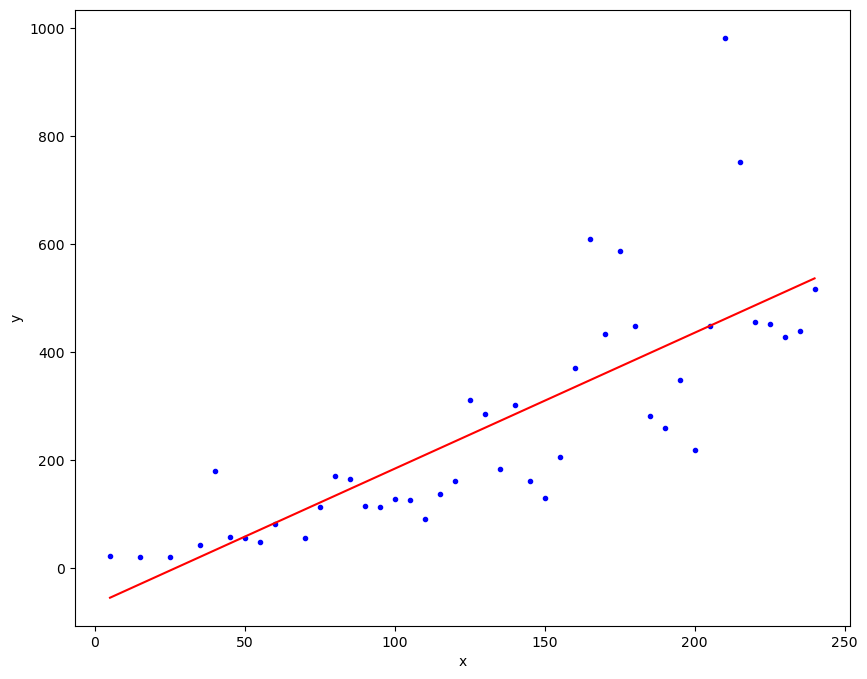

In [424]:
plt.figure(figsize = (10,8))
plt.plot(x, y, 'b.')
plt.plot(x, yn, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [332]:
(ss['mean'].rolling(rr=10).mean()).plot()
plt.xlim(0,500)

NameError: name 'ss' is not defined

## GOM background

In [14]:
GOMECC=pd.read_excel('Temp_data/GOMECC_USF_DIC_UW.xls').rename(columns={'GMT':'time'}).set_index('time').to_xarray()

DICts=GOMECC.DIC.where(GOMECC.DIC>0,np.nan).interpolate_na(dim='time')


In [15]:
DICts

<xarray.DataArray 'DIC' (time: 2879)>
array([1998.48682634, 2001.48913306, 1993.58459952, ..., 1992.46619235,
       1988.93384105, 1989.77586562])
Coordinates:
  * time     (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T20:00:49

In [16]:
DICts=GOMECC.DIC.where(GOMECC.DIC>0,np.nan).interpolate_na(dim='time')
DICts_nrm=(DICts-DICts.mean(dim='time'))/DICts.std(dim='time')

In [17]:
DICts.diff(dim='time').std(dim='time')

<xarray.DataArray 'DIC' ()>
array(8.88125135)

<xarray.Dataset>
Dimensions:        (time: 2879)
Coordinates:
  * time           (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T2...
Data variables:
    Latitude       (time) object '2859.8631N' '2859.8617N' ... '3738.2554N'
    Longitude      (time) object '09459.9804W' '09459.9787W' ... '06825.0758W'
    TSG-Unit-Temp  (time) float64 29.11 29.1 29.09 29.09 ... 29.46 29.53 29.41
    MicroSal       (time) float64 30.16 30.15 30.15 30.11 ... 36.07 36.08 36.08
    DIC            (time) float64 1.998e+03 2.001e+03 ... 1.989e+03 1.99e+03
    fCO2           (time) float64 -999.0 -999.0 -999.0 ... -999.0 402.9 401.1

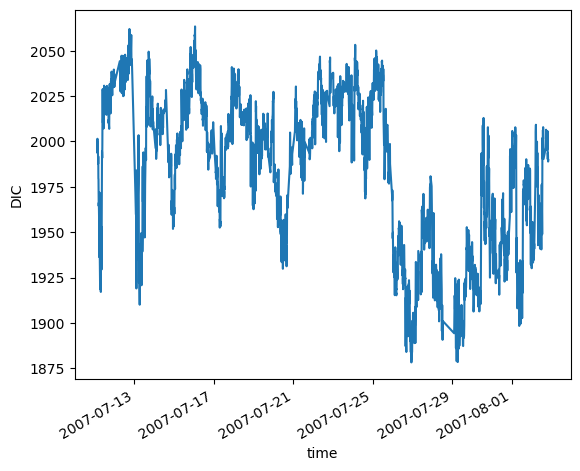

In [19]:
DICts.plot()

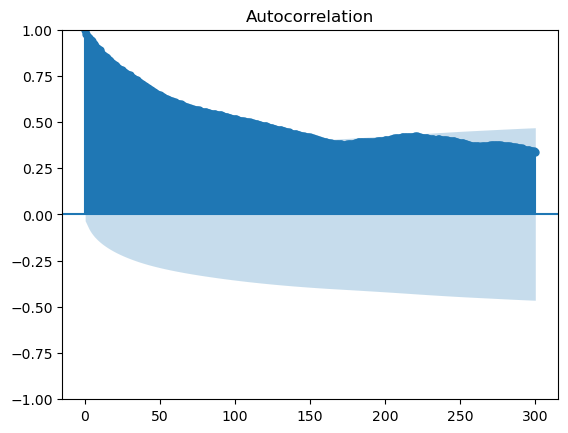

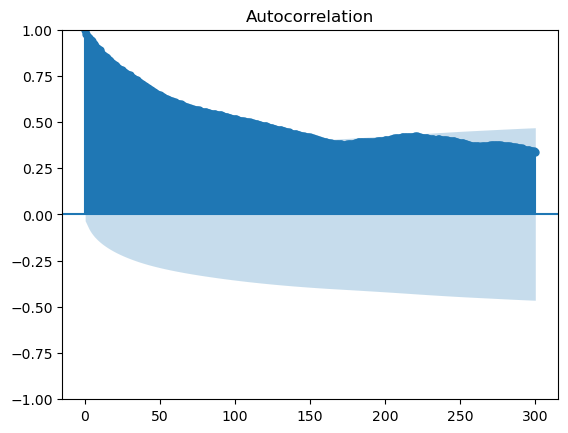

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(DICts_nrm,lags=300)

In [ ]:
DICts.mean(dim='time')

<xarray.DataArray 'DIC' ()>
array(1984.81630719)

In [ ]:
DICts.var(dim='time')

<xarray.DataArray 'DIC' ()>
array(1750.45051547)

In [450]:
DICts.time

<xarray.DataArray 'time' (time: 2879)>
array(['2007-07-11T03:38:30.000000000', '2007-07-11T03:47:15.000000000',
       '2007-07-11T03:56:01.000000000', ..., '2007-08-02T19:43:25.000000000',
       '2007-08-02T19:52:07.000000000', '2007-08-02T20:00:49.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T20:00:49

In [456]:
DICts.resample(time='15T').interpolate().diff(dim='time').std()

<xarray.DataArray 'DIC' ()>
array(8.00283905)

## Power single source

In [45]:
field=xr.open_dataset('Temp_data/fields_24.nc')
field


<xarray.Dataset>
Dimensions:  (time: 121, x: 200, y: 100)
Coordinates:
  * x        (x) float64 2.824e+05 2.829e+05 2.833e+05 ... 3.065e+05 3.07e+05
  * y        (y) float64 3.203e+06 3.203e+06 3.204e+06 ... 3.215e+06 3.215e+06
  * time     (time) datetime64[ns] 1998-10-01T01:00:00 ... 1998-10-06T01:00:00
Data variables:
    C        (time, x, y) float64 ...
Attributes: (12/33)
    max_prob:              0.0007019417826086283
    sum_prob:              1.2551407
    risk file:             ar56.8928.bm1310.slp3d.migration_conv_AGF_1_netcdf.nc
    threshold:             0.1
    cluster:               dbscan
    Probe file:            Indata/Probes/Probes_ar56_ex3.nc
    ...                    ...
    Fill type:             nearest extrapolation
    Downsampling:          False
    Downsampling factor:   16.0
    source tag:            24
    Origin:                [ 294703.42809929 3209239.72901602]
    location_probability:  60.084686

In [430]:
def read_one(filenm='Temp_data/statistics_24.nc'):
    print('Open: '+ filenm)
    stats=xr.open_dataset('Temp_data/statistics_24.nc')

    indx=stats['mean'].argmax(dim=['x','y'])
    
    #mxs=inarr.isel(x=indx['x'],y=indx['y'])
    stats['xs']=stats.x-stats.x.isel(x=indx['x'])   
    stats['ys']=stats.y-stats.y.isel(y=indx['y'])
    stats['r']=np.sqrt(stats.xs**2+stats.ys**2)
    stats= stats.assign_coords(r=stats.r)
    stats= stats.assign_coords(xs=stats.xs)
    stats= stats.assign_coords(ys=stats.ys)
    #stats=stats.stack(z=['x','y'])
    return stats

In [431]:
files=glob.glob('Temp_data/statistics_*[0-99].nc')
all_stat=[]
for file in files:
    all_stat.append(read_one(file))

all_stat=xr.concat(all_stat,dim='source')

Open: Temp_data/statistics_00.nc
Open: Temp_data/statistics_01.nc
Open: Temp_data/statistics_02.nc
Open: Temp_data/statistics_03.nc
Open: Temp_data/statistics_04.nc
Open: Temp_data/statistics_05.nc
Open: Temp_data/statistics_06.nc
Open: Temp_data/statistics_07.nc
Open: Temp_data/statistics_08.nc
Open: Temp_data/statistics_09.nc
Open: Temp_data/statistics_10.nc
Open: Temp_data/statistics_11.nc
Open: Temp_data/statistics_12.nc
Open: Temp_data/statistics_13.nc
Open: Temp_data/statistics_14.nc
Open: Temp_data/statistics_15.nc
Open: Temp_data/statistics_16.nc
Open: Temp_data/statistics_17.nc
Open: Temp_data/statistics_18.nc
Open: Temp_data/statistics_19.nc
Open: Temp_data/statistics_20.nc
Open: Temp_data/statistics_21.nc
Open: Temp_data/statistics_22.nc
Open: Temp_data/statistics_23.nc
Open: Temp_data/statistics_24.nc
Open: Temp_data/statistics_25.nc
Open: Temp_data/statistics_26.nc
Open: Temp_data/statistics_27.nc
Open: Temp_data/statistics_28.nc
Open: Temp_data/statistics_29.nc
Open: Temp

In [432]:
stata=all_stat.stack(z=['source','x','y']).groupby_bins('r', np.r_[0:3000:10]).mean(skipna=True)
stata

<xarray.Dataset>
Dimensions:         (dt: 3, r_bins: 299)
Coordinates:
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
  * r_bins          (r_bins) object (0, 10] (10, 20] ... (2980, 2990]
Data variables:
    mean            (r_bins) float64 0.2819 0.2567 0.2087 ... 0.0005322 0.00043
    var             (r_bins) float64 0.208 0.1577 0.103 ... 4.779e-06 3.15e-06
    max             (r_bins) float64 2.244 1.866 1.465 ... 0.007617 0.004853
    delta_mean      (r_bins, dt) float64 0.0002924 0.0005848 ... 8.922e-07
    delta_mean_abs  (r_bins, dt) float64 0.01604 0.03146 ... 5.764e-05 0.0001141
    delta_var       (r_bins, dt) float64 0.002249 0.008637 ... 2.625e-07
    delta_max       (r_bins, dt) float64 0.3591 0.6215 ... 0.000638 0.001227
    delta_min       (r_bins, dt) float64 -0.2856 -0.5037 ... -0.0006768 -0.0013
Attributes: (12/33)
    max_prob:              0.0007019417826086283
    sum_prob:              1.2551407
    risk file:             ar56.8928.bm1310.slp3d.migration_conv_AGF_1_netcdf.nc
    threshold:             0.1
    cluster:               dbscan
    Probe file:            Indata/Probes/Probes_ar56_ex3.nc
    ...                    ...
    Fill type:             nearest extrapolation
    Downsampling:          False
    Downsampling factor:   16.0
    source tag:            24
    Origin:                [ 294703.42809929 3209239.72901602]
    location_probability:  60.084686

In [434]:
stata=stata.assign_coords(r=('r_bins',np.asarray([v.mid for v in stata['r_bins'].values] )))
stata

<xarray.Dataset>
Dimensions:         (dt: 3, r_bins: 299)
Coordinates:
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
  * r_bins          (r_bins) object (0, 10] (10, 20] ... (2980, 2990]
    r               (r_bins) float64 5.0 15.0 25.0 ... 2.975e+03 2.985e+03
Data variables:
    mean            (r_bins) float64 0.2819 0.2567 0.2087 ... 0.0005322 0.00043
    var             (r_bins) float64 0.208 0.1577 0.103 ... 4.779e-06 3.15e-06
    max             (r_bins) float64 2.244 1.866 1.465 ... 0.007617 0.004853
    delta_mean      (r_bins, dt) float64 0.0002924 0.0005848 ... 8.922e-07
    delta_mean_abs  (r_bins, dt) float64 0.01604 0.03146 ... 5.764e-05 0.0001141
    delta_var       (r_bins, dt) float64 0.002249 0.008637 ... 2.625e-07
    delta_max       (r_bins, dt) float64 0.3591 0.6215 ... 0.000638 0.001227
    delta_min       (r_bins, dt) float64 -0.2856 -0.5037 ... -0.0006768 -0.0013
Attributes: (12/33)
    max_prob:              0.0007019417826086283
    sum_prob:              1.2551407
    risk file:             ar56.8928.bm1310.slp3d.migration_conv_AGF_1_netcdf.nc
    threshold:             0.1
    cluster:               dbscan
    Probe file:            Indata/Probes/Probes_ar56_ex3.nc
    ...                    ...
    Fill type:             nearest extrapolation
    Downsampling:          False
    Downsampling factor:   16.0
    source tag:            24
    Origin:                [ 294703.42809929 3209239.72901602]
    location_probability:  60.084686

In [388]:
fact=120/stata['mean'].max(dim='r_bins')
fact

<xarray.DataArray 'mean' ()>
array(425.67486242)

(0.0, 500.0)

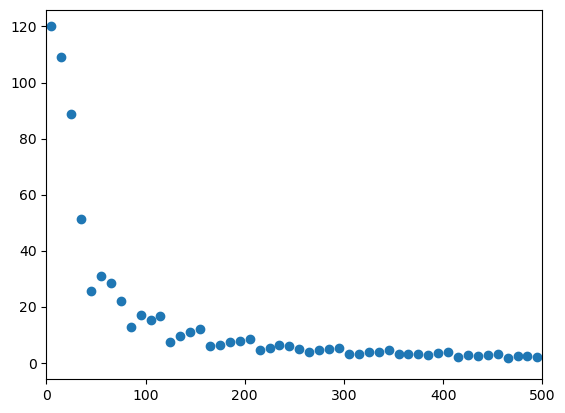

In [389]:
plt.scatter(x=stata.r,y=fact*stata['mean'])
plt.xlim(0,500)

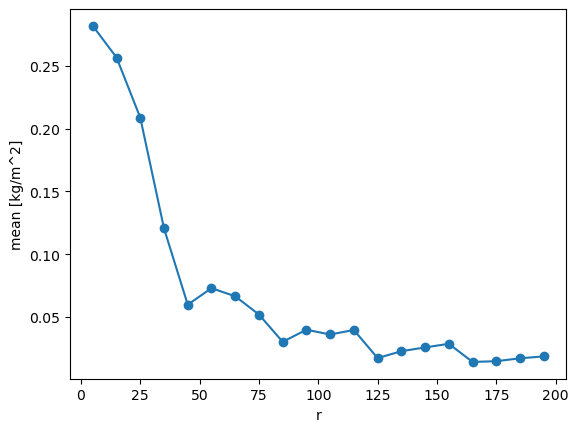

In [413]:
pltfld=stata.where(stata['r']<200,drop=True)['mean']
pltfld.plot(x='r',marker='o')

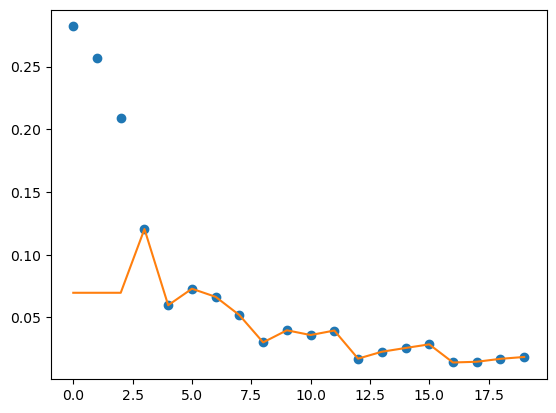

In [425]:
from hampel import hampel
yh=hampel(pd.Series(pltfld.values), window_size=5, n=1, imputation=True)
y=pltfld.values
plt.plot(y,'o')
plt.plot(yh)

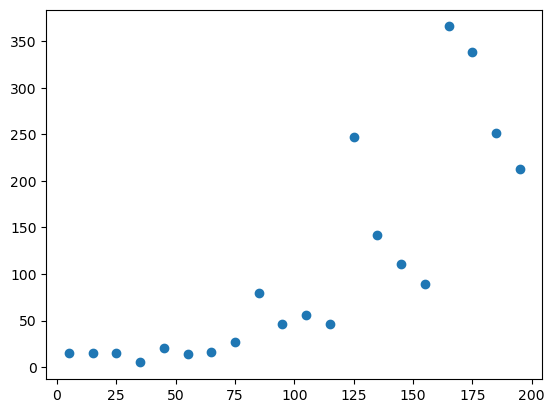

In [426]:
x=pltfld.r.values
y=(1.96+0.84)**2/(fact.values*yh/41)**2
#yh=hampel(pd.Series(y), window_size=5, n=3, imputation=True)
plt.scatter(x=x,y=y)
#plt.plot(x,yh)#np.sqrt(stats['var']))**2)
#plt.xlim(0,2000)

In [416]:
y

array([  0.91521111,   1.10364147,   1.66923685,   5.0117279 ,
        20.38436601,  13.69409358,  16.48371819,  27.04797871,
        80.15062503,  46.03118731,  56.18498403,  46.50870027,
       247.29419101, 141.84302105, 110.56932107,  89.25447766,
       365.85103779, 338.186681  , 251.45898332, 212.69805087])

In [429]:
A = np.vstack([x, np.ones(len(x))]).T

# turn y into a column vector
#y = y.T#[:, np.newaxis]
alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y.T)
print(alpha)
yn=alpha[0]*x + alpha[1]

[  1.56636121 -50.95465356]


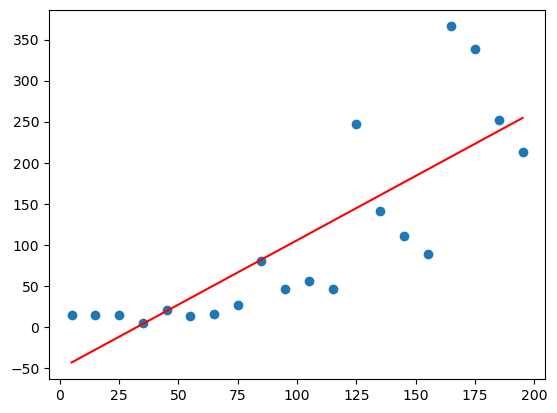

In [428]:
plt.plot(x,yn,'r')
plt.scatter(x,y)